# Next Pitch Prediction using GRUs

The first series of tests will be carried out using basic GRUs. GRUs are a type of RNN that are simpler than LSTMs and are often used when the data is not too complex. The idea is to use the GRU to predict the next pitch in a sequence of pitches

## Data loading and sequencing

In [17]:
import os
import tensorflow as tf
import keras_tuner

os.chdir('../..')
tf.keras.utils.set_random_seed(42)

import matplotlib.pyplot as plt
from utils.plot_utils import smooth_curve, plot_ensemble_history

The first step is to load the pitch data and sequence it into a format that can be used to train the LSTM. For this, the preprocessing utils developed earlier will be used.

It is also necessary to split the data into training, validation and test sets. A 60-20-20 split will be done using Scikit Learn.

In [3]:
from utils import preprocessing
from sklearn.model_selection import train_test_split

X, y_pitch, y_vertical, y_horizontal = preprocessing.get_sequences(os.path.join('data', 'raw', 'wade_miley.csv'))

# Split the data into training, validation, and testing sets
X_train, X_temp, y_pitch_train, y_pitch_temp, y_vertical_train, y_vertical_temp, y_horizontal_train, y_horizontal_temp = train_test_split(
    X, y_pitch, y_vertical, y_horizontal, test_size=0.4, random_state=54)

X_val, X_test, y_pitch_val, y_pitch_test, y_vertical_val, y_vertical_test, y_horizontal_val, y_horizontal_test = train_test_split(
    X_temp, y_pitch_temp, y_vertical_temp, y_horizontal_temp, test_size=0.5, random_state=42)

num_pitches = y_pitch.shape[1]
num_vertical_locs = y_vertical.shape[1]
num_horizontal_locs = y_horizontal.shape[1]

## Develop a model that does better than the baseline

The first step in the process is to develop a basic model that beats the baseline. This model will be a ensemble of LSTMs with 1 hidden layer with 128 units.

To streamline the process, two new functions will be developed:
- `build_network`: which builds a single LSTM network with the specified parameters and compiles it.
- `build_model`: which builds an ensemble of LSTM networks. This function will be used by Keras Tuner to optimize the hyperparameters of the model.

In [4]:
def build_network(input_layer, num_targets, name='', num_hidden_units=128, num_hidden_layers=1, activation='tanh', recurrent_activation='sigmoid', reg=None, dropout=None):
    
    # Hidden layers
    x = input_layer
    for i in range(num_hidden_layers - 1):
        layer_name = f"{name}_hidden_{i+1}"
        if reg:
            x = tf.keras.layers.GRU(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True, kernel_regularizer=reg, name=layer_name)(x)
        else:
            x = tf.keras.layers.GRU(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True, name=layer_name)(x)
        if dropout:
            x = tf.keras.layers.Dropout(dropout, name=f"{layer_name}_dropout")(x)
    
    # Last hidden layer without return_sequences
    layer_name = f"{name}_hidden_{num_hidden_layers}"
    if reg:
        x = tf.keras.layers.GRU(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=False, kernel_regularizer=reg, name=layer_name)(x)
    else:
        x = tf.keras.layers.GRU(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=False, name=layer_name)(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout, name=f"{layer_name}_dropout")(x)

    # Output layer
    outputs = tf.keras.layers.Dense(units=num_targets, activation='softmax', name=f'{name}_output')(x)

    return outputs

It is important to define the search space for the hyperparameters. The following hyperparameters will be optimized:

- **Number of units in the hidden layer**: This will be chosen from the values [128, 256, 512].
- **Number of hidden layers**: This will be an integer value between 1 and 3.
- **Activation function**: This will be chosen from the values ['relu', 'elu', 'tanh', 'sigmoid'].
- **Recurrent activation function**: This will be chosen from the values ['relu', 'elu', 'sigmoid', 'tanh'].

In [5]:
def build_model(hp):
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                         num_hidden_units=hp.Choice('num_hidden_units', values=[128, 256, 512]),
                         activation=hp.Choice('activation', values=['relu', 'elu', 'tanh', 'sigmoid']),
                         recurrent_activation=hp.Choice('recurrent_activation', values=['relu', 'elu', 'sigmoid', 'tanh']))
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                          num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                          num_hidden_units=hp.Choice('num_hidden_units', values=[128, 256, 512]),
                          activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                          recurrent_activation=hp.Choice('recurrent_activation', values=['sigmoid', 'tanh']))
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                            num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=5, step=1),
                            num_hidden_units=hp.Choice('num_hidden_units', values=[128, 256, 512]),
                            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                            recurrent_activation=hp.Choice('recurrent_activation', values=['sigmoid', 'tanh']))

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

To avoid wasting time and computational resources, we will implement early stopping with a patience of 5 epochs. Since the `EarlyStopping` callback from Tensorflow is designed for a single model, we will implement a custom callback that will monitor every model in the ensemble and freeze the weights independently if the model performance starts to degrade.

In [6]:
from utils.callbacks import FreezeOutputCallback

freeze_output_callback = FreezeOutputCallback(patience=5)

In [14]:
# Create an instance of the HyperParameters object
hp = keras_tuner.HyperParameters()

# Test the build_model function
model = build_model(hp)

# Train the model
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[freeze_output_callback],
                             verbose=0
                            )


Freezing output vertical at 6 epochs.

Freezing output horizontal at 26 epochs.

Freezing output pitch at 37 epochs.

All outputs frozen. Stopping training at epoch 37.


In [15]:
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - horizontal_output_accuracy: 0.5005 - loss: nan - pitch_output_accuracy: 0.5155 - vertical_output_accuracy: 0.6248
Pitch Test Accuracy: 0.4925875961780548
Vertical Test Accuracy: 0.5111185908317566
Horizontal Test Accuracy: 0.6263477206230164


We can notice a considerable improvement in the model performance.

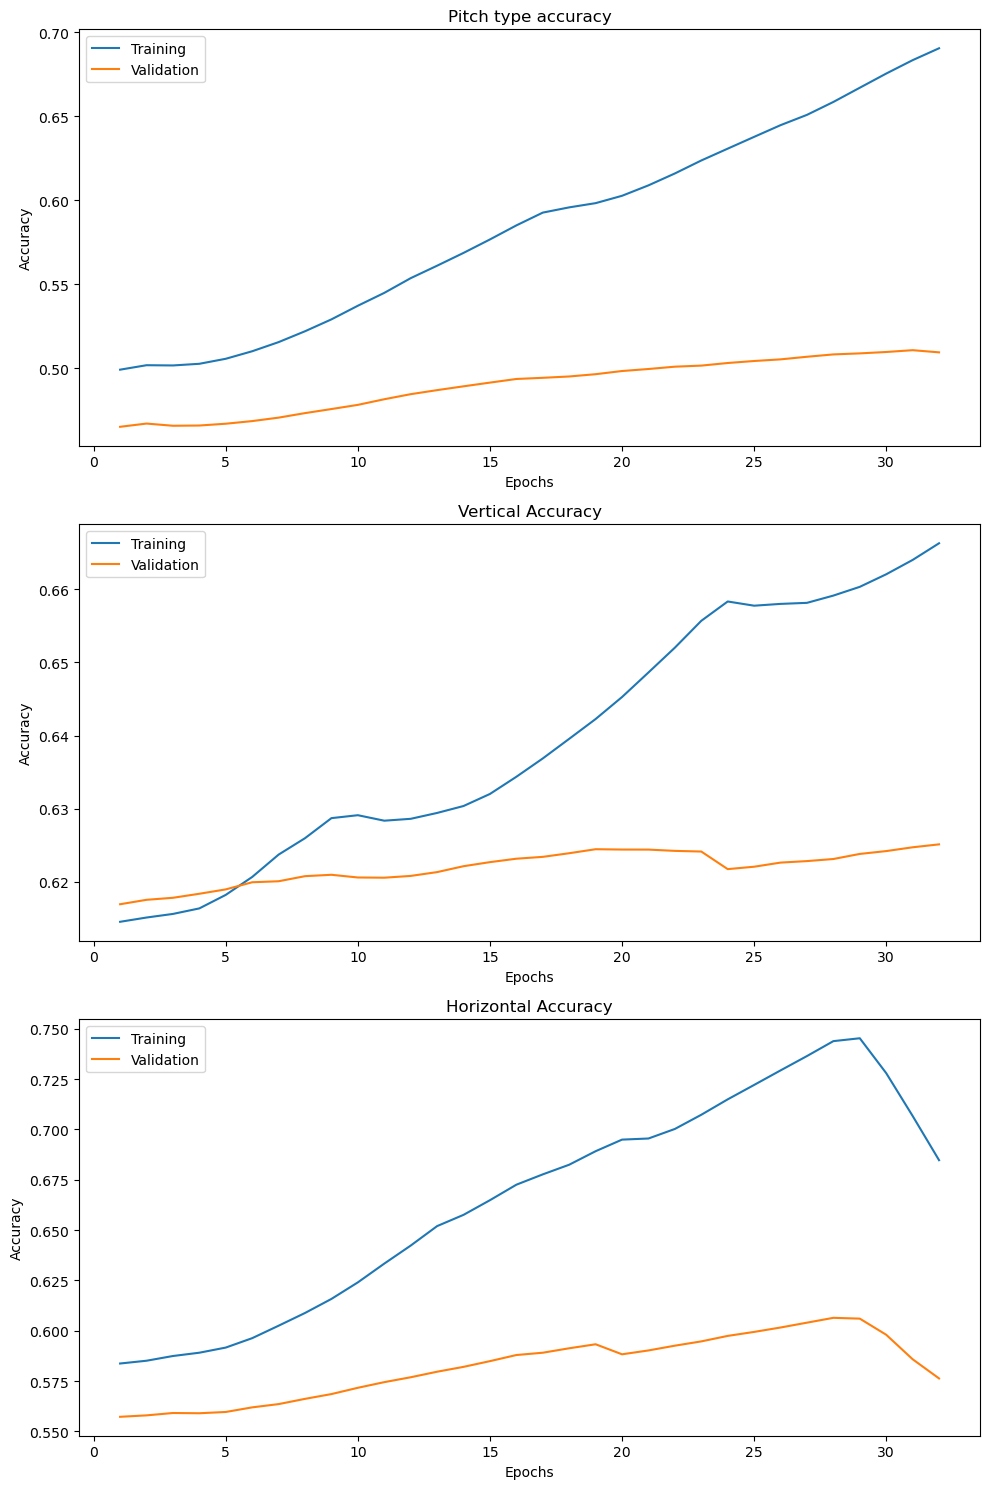

In [16]:
from utils.plot_utils import plot_ensemble_history

plot_ensemble_history(history)

## Scale up

Now, it is time to scale up the model to increase its performance. For this, we will run Bayesian optimization using the `BayesianOptimization` class from the Keras Tuner library. The search space will be the one defined earlier. The optimization will be carried out for 10 iterations.

In [17]:
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective=[keras_tuner.Objective('val_vertical_output_accuracy', direction='max'),
               keras_tuner.Objective('val_horizontal_output_accuracy', direction='max'),
               keras_tuner.Objective('val_pitch_output_accuracy', direction='max')],
    max_trials=10,
    project_name='GRU_Ensemble'
)

tuner.search(X_train, 
             {'pitch_output': y_pitch_train,
              'vertical_output': y_vertical_train,
              'horizontal_output': y_horizontal_train},
             epochs=100, batch_size=64, 
             validation_data=(X_val, 
                              {'pitch_output': y_pitch_val,
                               'vertical_output': y_vertical_val,
                               'horizontal_output': y_horizontal_val}),
             callbacks=[freeze_output_callback],
            )

Trial 10 Complete [00h 03m 23s]
multi_objective: -1.6108490824699402

Best multi_objective So Far: -1.9858490228652954
Total elapsed time: 00h 36m 33s


In [18]:
import pandas as pd

# Get the tuner results
tuner_results = tuner.oracle.get_best_trials(num_trials=10)

# Extract relevant information
results = []
for trial in tuner_results:
    trial_summary = {
        'Trial ID': trial.trial_id,
        'Hidden layers': trial.hyperparameters.values['num_hidden_layers'],
        'Hidden units': trial.hyperparameters.values['num_hidden_units'],
        'Activation': trial.hyperparameters.values['activation'],
        'Recurrent Activation': trial.hyperparameters.values['recurrent_activation'],
        'Score': trial.score,
        'Pitch Accuracy': trial.metrics.get_last_value('val_pitch_output_accuracy'),
        'Vertical Accuracy': trial.metrics.get_last_value('val_vertical_output_accuracy'),
        'Horizontal Accuracy': trial.metrics.get_last_value('val_horizontal_output_accuracy')
    }
    results.append(trial_summary)

# Create a DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('lstm_search_results.csv', index=False)

# Display the results
results_df

,Trial ID,Hidden layers,Hidden units,Activation,Recurrent Activation,Score,Pitch Accuracy,Vertical Accuracy,Horizontal Accuracy
0,05,1,128,relu,sigmoid,-1.985849,0.579515,0.718329,0.688005
1,04,3,128,relu,tanh,-1.951146,0.590633,0.701146,0.659367
2,07,1,256,relu,relu,-1.768868,0.535377,0.622305,0.611186
3,01,1,256,tanh,elu,-1.739555,0.496631,0.646900,0.596024
4,03,2,256,relu,relu,-1.733154,0.502022,0.631402,0.599730
5,06,3,256,relu,relu,-1.663073,0.482817,0.616914,0.563342
6,08,3,256,tanh,elu,-1.620283,0.457547,0.610175,0.552561
7,09,1,512,sigmoid,elu,-1.610849,0.446092,0.616914,0.547844
8,00,2,256,elu,relu,-1.574461,0.454852,0.613208,0.506402
9,02,3,512,tanh,relu,-1.556267,0.409030,0.616914,0.530323


It does not seem that the model complexity is the main factor in the model performance. The best model found has only 1 hidden layer with 128 units. The best activation functions are 'relu' and 'sigmoid'.

In order to maximize the model performance, we will use the hyperparameters from Trial 05 for location prediction and those from Trial 04 for pitch type prediction in the next steps. This is because the model in Trial 05 has the best performance for location prediction and the model in Trial 04 has the best performance for pitch type prediction.

## Regularizing the model

In [19]:
def build_model():
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_layers=3,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='tanh')
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid')
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid')

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [20]:
model = build_model()
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[freeze_output_callback],
                             verbose=1
                            )

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - horizontal_output_accuracy: 0.4692 - loss: 3.6231 - pitch_output_accuracy: 0.3707 - vertical_output_accuracy: 0.5885 - val_horizontal_output_accuracy: 0.5239 - val_loss: 3.2343 - val_pitch_output_accuracy: 0.4107 - val_vertical_output_accuracy: 0.6169
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - horizontal_output_accuracy: 0.5381 - loss: 3.2039 - pitch_output_accuracy: 0.4335 - vertical_output_accuracy: 0.6097 - val_horizontal_output_accuracy: 0.5398 - val_loss: 3.1610 - val_pitch_output_accuracy: 0.4508 - val_vertical_output_accuracy: 0.6169
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - horizontal_output_accuracy: 0.5515 - loss: 3.1091 - pitch_output_accuracy: 0.4718 - vertical_output_accuracy: 0.6101 - val_horizontal_output_accuracy: 0.5367 - val_loss: 3.1254 - val_pitch_output_accuracy: 0.4639 - val_vertical_output_accuracy: 0.6189
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - horizontal_output_a

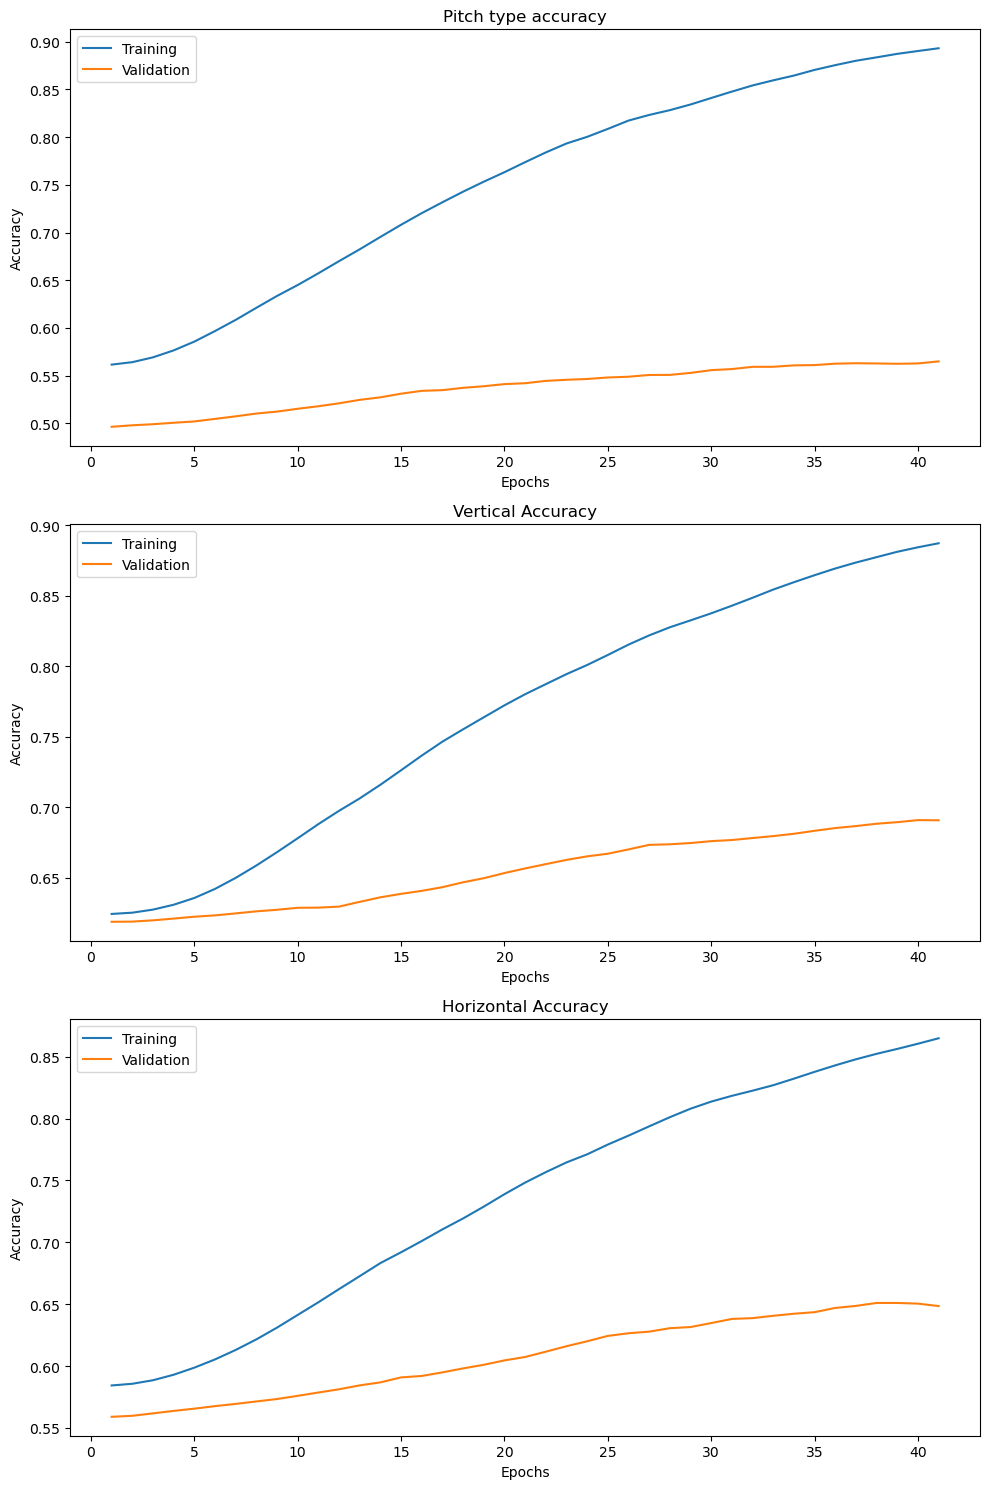

In [21]:
plot_ensemble_history(history)

We see no signs of overfitting at the moment. However, it is always good to regularize the model to avoid overfitting. For this, we will test different regularization techniques such as dropout and regularization.

### Regularization

In [7]:
def build_model(reg=None, drop=0):
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_layers=3,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='tanh',
                         reg=reg,
                         dropout=drop)
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid',
                         reg=reg,
                         dropout=drop)
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid',
                         reg=reg,
                         dropout=drop)

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [8]:
regularizations = [tf.keras.regularizers.l1(0.001), tf.keras.regularizers.l2(0.001), tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)]
histories = []

for reg in regularizations:
    print("Testing with regularization:", reg)
    model = build_model(reg=reg)
    history = model.fit(X_train, 
                                 {'pitch_output': y_pitch_train,
                                  'vertical_output': y_vertical_train,
                                  'horizontal_output': y_horizontal_train},
                                 epochs=100, batch_size=64, 
                                 validation_data=(X_val, 
                                                  {'pitch_output': y_pitch_val,
                                                   'vertical_output': y_vertical_val,
                                                   'horizontal_output': y_horizontal_val}),
                                 callbacks=[freeze_output_callback],
                                 verbose=0
                                )
    histories.append(history)

Testing with regularization: <keras.src.regularizers.regularizers.L1 object at 0x0000027DB4D65310>

Freezing output vertical at 6 epochs.

Freezing output pitch at 16 epochs.

Freezing output horizontal at 29 epochs.

All outputs frozen. Stopping training at epoch 29.
Testing with regularization: <keras.src.regularizers.regularizers.L2 object at 0x0000027DB2F80310>

Freezing output vertical at 19 epochs.

Freezing output pitch at 30 epochs.

Freezing output horizontal at 34 epochs.

All outputs frozen. Stopping training at epoch 34.
Testing with regularization: <keras.src.regularizers.regularizers.L1L2 object at 0x0000027DB45C3F50>

Freezing output vertical at 6 epochs.

Freezing output horizontal at 9 epochs.

Freezing output pitch at 27 epochs.

All outputs frozen. Stopping training at epoch 27.


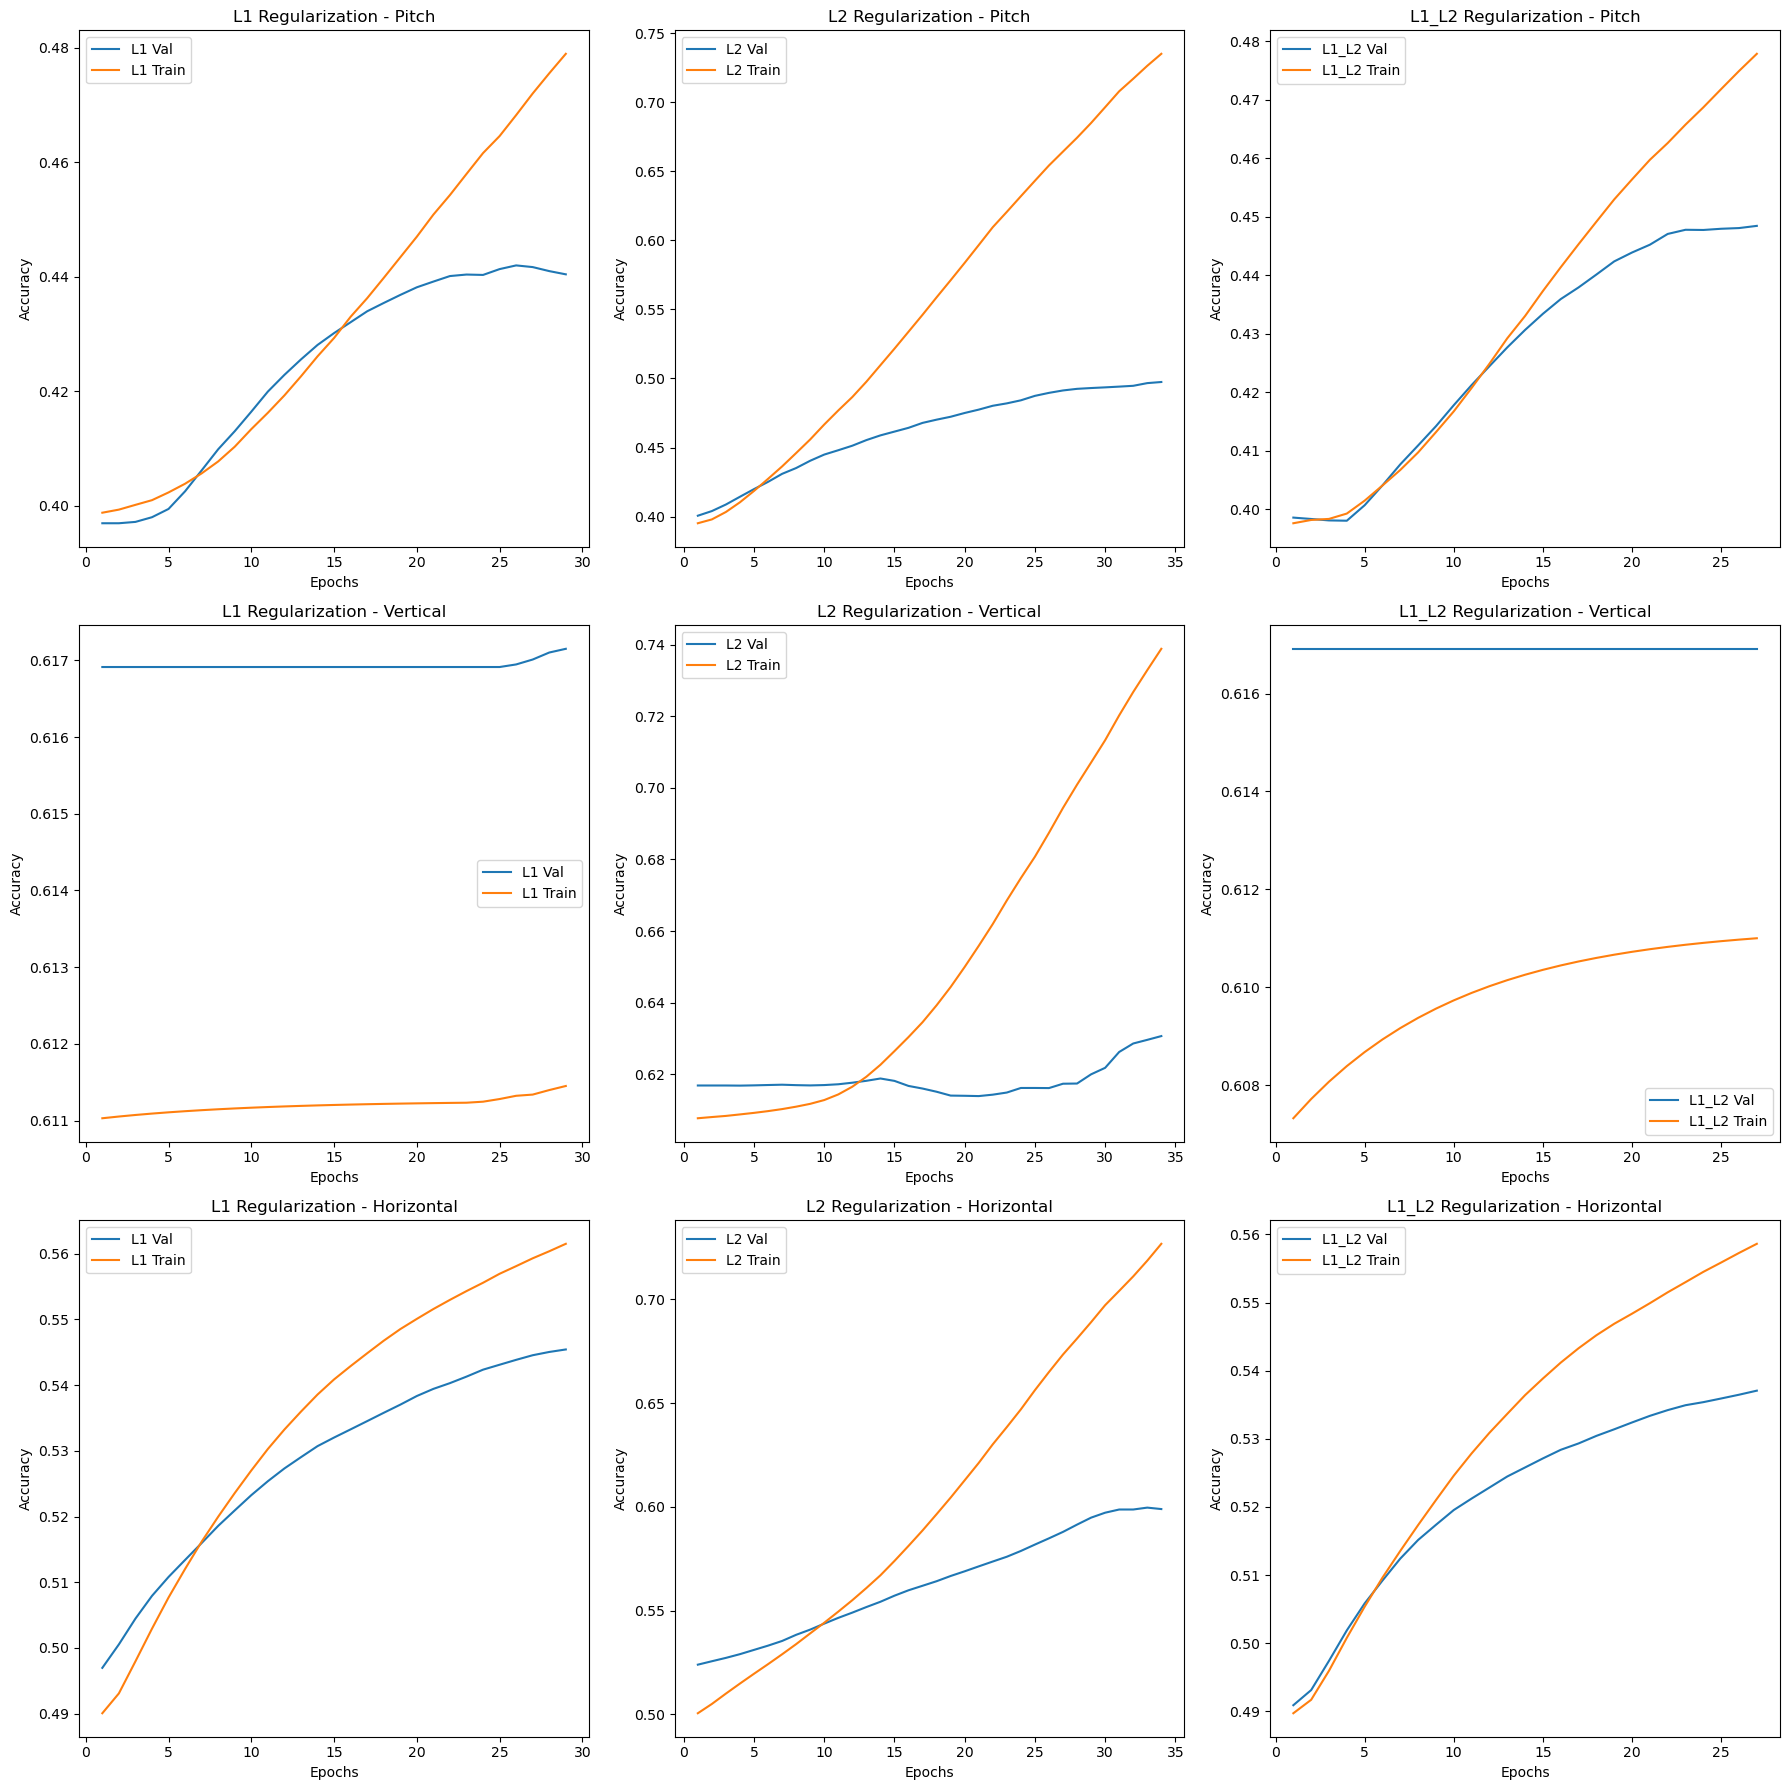

In [9]:
# Smooth the curves for better visualization
smooth_l1_pitch_val = smooth_curve(histories[0].history['val_pitch_output_accuracy'])
smooth_l2_pitch_val = smooth_curve(histories[1].history['val_pitch_output_accuracy'])
smooth_l1_l2_pitch_val = smooth_curve(histories[2].history['val_pitch_output_accuracy'])

smooth_l1_pitch_train = smooth_curve(histories[0].history['pitch_output_accuracy'])
smooth_l2_pitch_train = smooth_curve(histories[1].history['pitch_output_accuracy'])
smooth_l1_l2_pitch_train = smooth_curve(histories[2].history['pitch_output_accuracy'])

smooth_l1_vertical_val = smooth_curve(histories[0].history['val_vertical_output_accuracy'])
smooth_l2_vertical_val = smooth_curve(histories[1].history['val_vertical_output_accuracy'])
smooth_l1_l2_vertical_val = smooth_curve(histories[2].history['val_vertical_output_accuracy'])

smooth_l1_vertical_train = smooth_curve(histories[0].history['vertical_output_accuracy'])
smooth_l2_vertical_train = smooth_curve(histories[1].history['vertical_output_accuracy'])
smooth_l1_l2_vertical_train = smooth_curve(histories[2].history['vertical_output_accuracy'])

smooth_l1_horizontal_val = smooth_curve(histories[0].history['val_horizontal_output_accuracy'])
smooth_l2_horizontal_val = smooth_curve(histories[1].history['val_horizontal_output_accuracy'])
smooth_l1_l2_horizontal_val = smooth_curve(histories[2].history['val_horizontal_output_accuracy'])

smooth_l1_horizontal_train = smooth_curve(histories[0].history['horizontal_output_accuracy'])
smooth_l2_horizontal_train = smooth_curve(histories[1].history['horizontal_output_accuracy'])
smooth_l1_l2_horizontal_train = smooth_curve(histories[2].history['horizontal_output_accuracy'])

# Create a collage of plots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot L1 regularization
axes[0, 0].plot(range(1, len(smooth_l1_pitch_val) + 1), smooth_l1_pitch_val, label='L1 Val')
axes[0, 0].plot(range(1, len(smooth_l1_pitch_train) + 1), smooth_l1_pitch_train, label='L1 Train')
axes[0, 0].set_title('L1 Regularization - Pitch')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

axes[1, 0].plot(range(1, len(smooth_l1_vertical_val) + 1), smooth_l1_vertical_val, label='L1 Val')
axes[1, 0].plot(range(1, len(smooth_l1_vertical_train) + 1), smooth_l1_vertical_train, label='L1 Train')
axes[1, 0].set_title('L1 Regularization - Vertical')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

axes[2, 0].plot(range(1, len(smooth_l1_horizontal_val) + 1), smooth_l1_horizontal_val, label='L1 Val')
axes[2, 0].plot(range(1, len(smooth_l1_horizontal_train) + 1), smooth_l1_horizontal_train, label='L1 Train')
axes[2, 0].set_title('L1 Regularization - Horizontal')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()

# Plot L2 regularization
axes[0, 1].plot(range(1, len(smooth_l2_pitch_val) + 1), smooth_l2_pitch_val, label='L2 Val')
axes[0, 1].plot(range(1, len(smooth_l2_pitch_train) + 1), smooth_l2_pitch_train, label='L2 Train')
axes[0, 1].set_title('L2 Regularization - Pitch')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

axes[1, 1].plot(range(1, len(smooth_l2_vertical_val) + 1), smooth_l2_vertical_val, label='L2 Val')
axes[1, 1].plot(range(1, len(smooth_l2_vertical_train) + 1), smooth_l2_vertical_train, label='L2 Train')
axes[1, 1].set_title('L2 Regularization - Vertical')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

axes[2, 1].plot(range(1, len(smooth_l2_horizontal_val) + 1), smooth_l2_horizontal_val, label='L2 Val')
axes[2, 1].plot(range(1, len(smooth_l2_horizontal_train) + 1), smooth_l2_horizontal_train, label='L2 Train')
axes[2, 1].set_title('L2 Regularization - Horizontal')
axes[2, 1].set_xlabel('Epochs')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].legend()

# Plot L1_L2 regularization
axes[0, 2].plot(range(1, len(smooth_l1_l2_pitch_val) + 1), smooth_l1_l2_pitch_val, label='L1_L2 Val')
axes[0, 2].plot(range(1, len(smooth_l1_l2_pitch_train) + 1), smooth_l1_l2_pitch_train, label='L1_L2 Train')
axes[0, 2].set_title('L1_L2 Regularization - Pitch')
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].legend()

axes[1, 2].plot(range(1, len(smooth_l1_l2_vertical_val) + 1), smooth_l1_l2_vertical_val, label='L1_L2 Val')
axes[1, 2].plot(range(1, len(smooth_l1_l2_vertical_train) + 1), smooth_l1_l2_vertical_train, label='L1_L2 Train')
axes[1, 2].set_title('L1_L2 Regularization - Vertical')
axes[1, 2].set_xlabel('Epochs')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].legend()

axes[2, 2].plot(range(1, len(smooth_l1_l2_horizontal_val) + 1), smooth_l1_l2_horizontal_val, label='L1_L2 Val')
axes[2, 2].plot(range(1, len(smooth_l1_l2_horizontal_train) + 1), smooth_l1_l2_horizontal_train, label='L1_L2 Train')
axes[2, 2].set_title('L1_L2 Regularization - Horizontal')
axes[2, 2].set_xlabel('Epochs')
axes[2, 2].set_ylabel('Accuracy')
axes[2, 2].legend()

plt.tight_layout()
plt.show()

We do not see any improvement in the model performance. It seems that the model is already well regularized. We will keep the model as it is.

### Dropout

In [10]:
dropout_rates = [0, 0.5]
histories_dropout = []

for dropout_rate in dropout_rates:
    print("Testing with dropout rate:", dropout_rate)
    model = build_model(drop=dropout_rate)
    history = model.fit(X_train, 
                                 {'pitch_output': y_pitch_train,
                                  'vertical_output': y_vertical_train,
                                  'horizontal_output': y_horizontal_train},
                                 epochs=100, batch_size=64, 
                                 validation_data=(X_val, 
                                                  {'pitch_output': y_pitch_val,
                                                   'vertical_output': y_vertical_val,
                                                   'horizontal_output': y_horizontal_val}),
                                 callbacks=[freeze_output_callback],
                                 verbose=0
                                )
    histories_dropout.append(history)

Testing with dropout rate: 0

Freezing output pitch at 31 epochs.

Freezing output horizontal at 32 epochs.

Freezing output vertical at 41 epochs.

All outputs frozen. Stopping training at epoch 41.
Testing with dropout rate: 0.5

Freezing output horizontal at 34 epochs.

Freezing output vertical at 37 epochs.

Freezing output pitch at 45 epochs.

All outputs frozen. Stopping training at epoch 45.


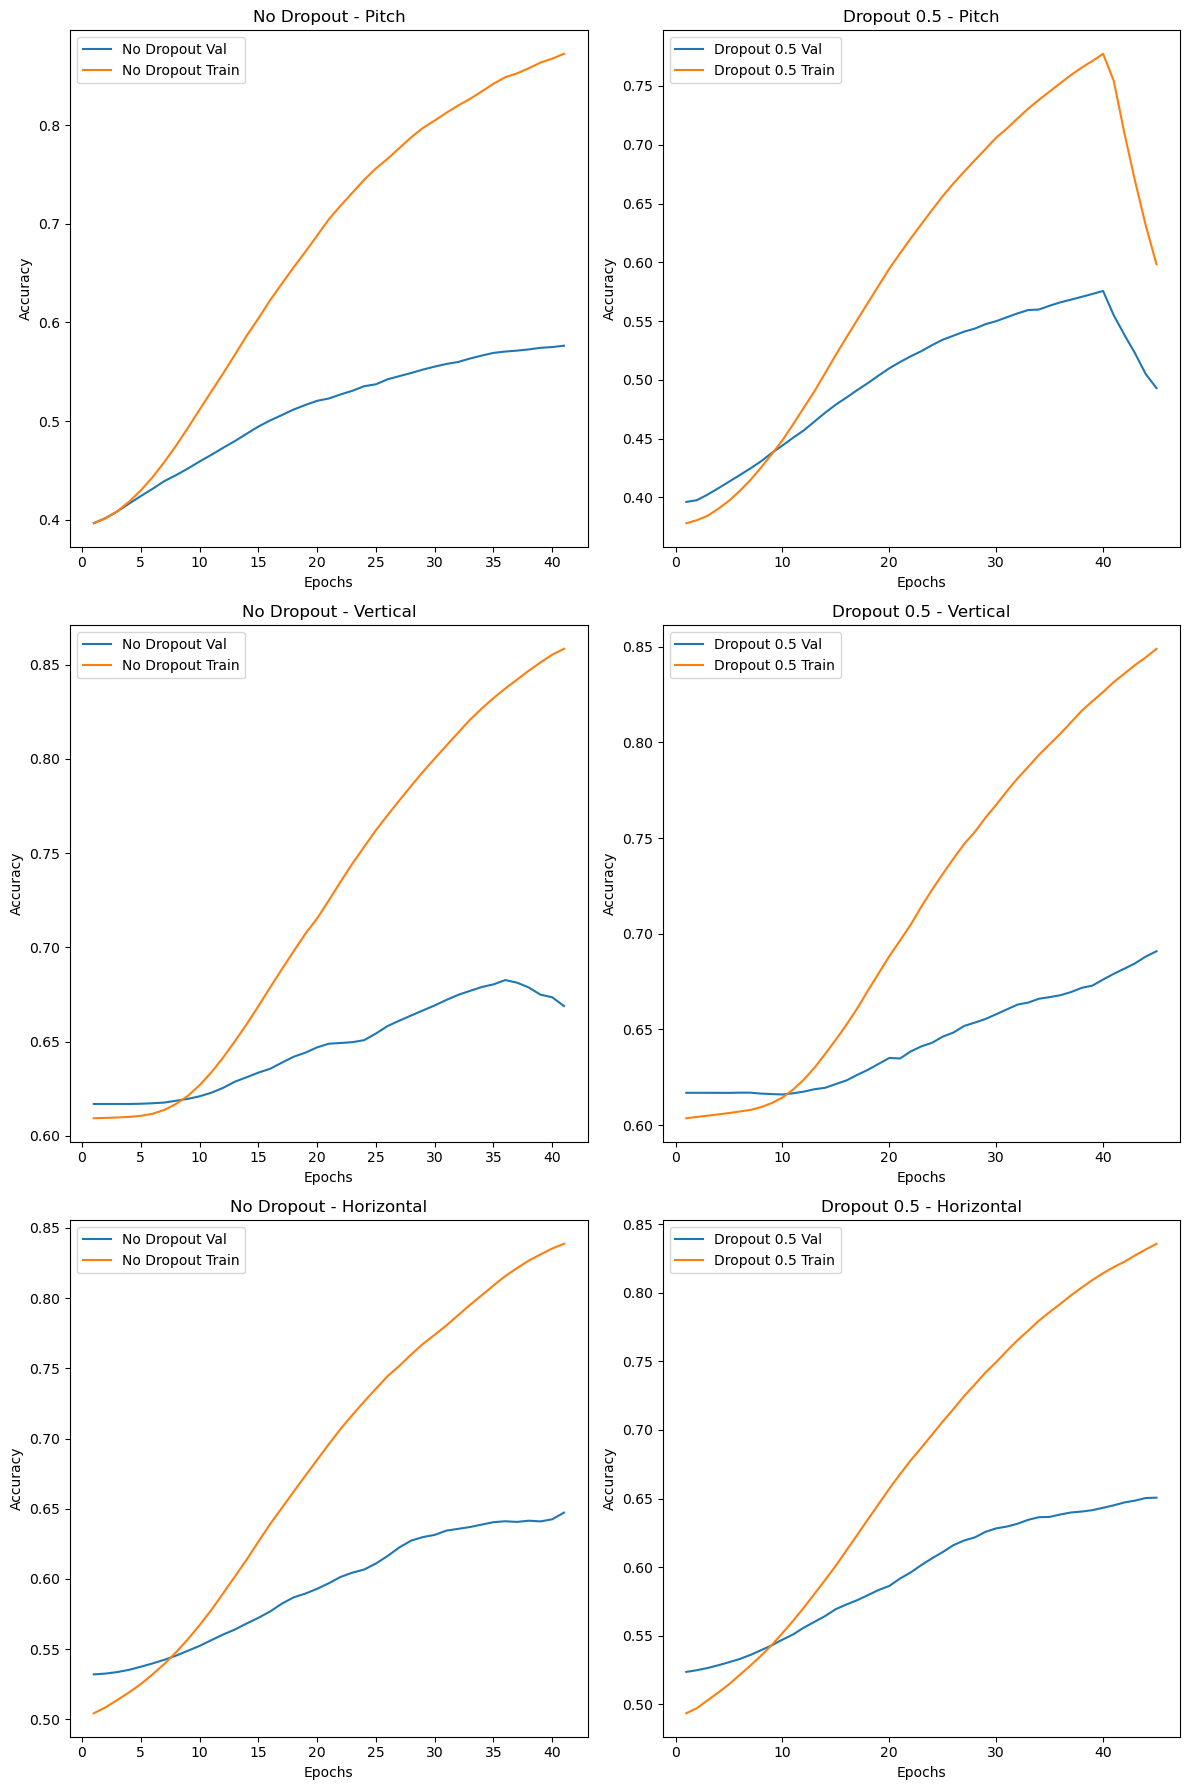

In [11]:
# Smooth the curves for better visualization
smooth_no_drop_pitch_val = smooth_curve(histories_dropout[0].history['val_pitch_output_accuracy'])
smooth_drop_05_pitch_val = smooth_curve(histories_dropout[1].history['val_pitch_output_accuracy'])
smooth_no_drop_pitch_train = smooth_curve(histories_dropout[0].history['pitch_output_accuracy'])
smooth_drop_05_pitch_train = smooth_curve(histories_dropout[1].history['pitch_output_accuracy'])

smooth_no_drop_vertical_val = smooth_curve(histories_dropout[0].history['val_vertical_output_accuracy'])
smooth_drop_05_vertical_val = smooth_curve(histories_dropout[1].history['val_vertical_output_accuracy'])
smooth_no_drop_vertical_train = smooth_curve(histories_dropout[0].history['vertical_output_accuracy'])
smooth_drop_05_vertical_train = smooth_curve(histories_dropout[1].history['vertical_output_accuracy'])

smooth_no_drop_horizontal_val = smooth_curve(histories_dropout[0].history['val_horizontal_output_accuracy'])
smooth_drop_05_horizontal_val = smooth_curve(histories_dropout[1].history['val_horizontal_output_accuracy'])
smooth_no_drop_horizontal_train = smooth_curve(histories_dropout[0].history['horizontal_output_accuracy'])
smooth_drop_05_horizontal_train = smooth_curve(histories_dropout[1].history['horizontal_output_accuracy'])

# Create a collage of plots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Plot without dropout for pitch
axes[0, 0].plot(range(1, len(smooth_no_drop_pitch_val) + 1), smooth_no_drop_pitch_val, label='No Dropout Val')
axes[0, 0].plot(range(1, len(smooth_no_drop_pitch_train) + 1), smooth_no_drop_pitch_train, label='No Dropout Train')
axes[0, 0].set_title('No Dropout - Pitch')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Plot with 0.5 dropout for pitch
axes[0, 1].plot(range(1, len(smooth_drop_05_pitch_val) + 1), smooth_drop_05_pitch_val, label='Dropout 0.5 Val')
axes[0, 1].plot(range(1, len(smooth_drop_05_pitch_train) + 1), smooth_drop_05_pitch_train, label='Dropout 0.5 Train')
axes[0, 1].set_title('Dropout 0.5 - Pitch')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plot without dropout for vertical
axes[1, 0].plot(range(1, len(smooth_no_drop_vertical_val) + 1), smooth_no_drop_vertical_val, label='No Dropout Val')
axes[1, 0].plot(range(1, len(smooth_no_drop_vertical_train) + 1), smooth_no_drop_vertical_train, label='No Dropout Train')
axes[1, 0].set_title('No Dropout - Vertical')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

# Plot with 0.5 dropout for vertical
axes[1, 1].plot(range(1, len(smooth_drop_05_vertical_val) + 1), smooth_drop_05_vertical_val, label='Dropout 0.5 Val')
axes[1, 1].plot(range(1, len(smooth_drop_05_vertical_train) + 1), smooth_drop_05_vertical_train, label='Dropout 0.5 Train')
axes[1, 1].set_title('Dropout 0.5 - Vertical')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

# Plot without dropout for horizontal
axes[2, 0].plot(range(1, len(smooth_no_drop_horizontal_val) + 1), smooth_no_drop_horizontal_val, label='No Dropout Val')
axes[2, 0].plot(range(1, len(smooth_no_drop_horizontal_train) + 1), smooth_no_drop_horizontal_train, label='No Dropout Train')
axes[2, 0].set_title('No Dropout - Horizontal')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()

# Plot with 0.5 dropout for horizontal
axes[2, 1].plot(range(1, len(smooth_drop_05_horizontal_val) + 1), smooth_drop_05_horizontal_val, label='Dropout 0.5 Val')
axes[2, 1].plot(range(1, len(smooth_drop_05_horizontal_train) + 1), smooth_drop_05_horizontal_train, label='Dropout 0.5 Train')
axes[2, 1].set_title('Dropout 0.5 - Horizontal')
axes[2, 1].set_xlabel('Epochs')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].legend()

plt.tight_layout()
plt.show()

We see that dropout improved the performance of the vertical location network, so we will keep it in that network. However, it did not improve the performance of the other two.

## Final Model

The final model will be trained using the hyperparameters from Trial 05 for the location networks and Trial 04 for the pitch type network.

In [14]:
def build_model():
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_layers=3,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='tanh')
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid',
                         dropout=0.5)
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid')

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [15]:
# Test the build_model function
model = build_model()

# Train the model
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[freeze_output_callback],
                             verbose=0
                            )


Freezing output pitch at 17 epochs.

Freezing output horizontal at 34 epochs.

Freezing output vertical at 42 epochs.

All outputs frozen. Stopping training at epoch 42.


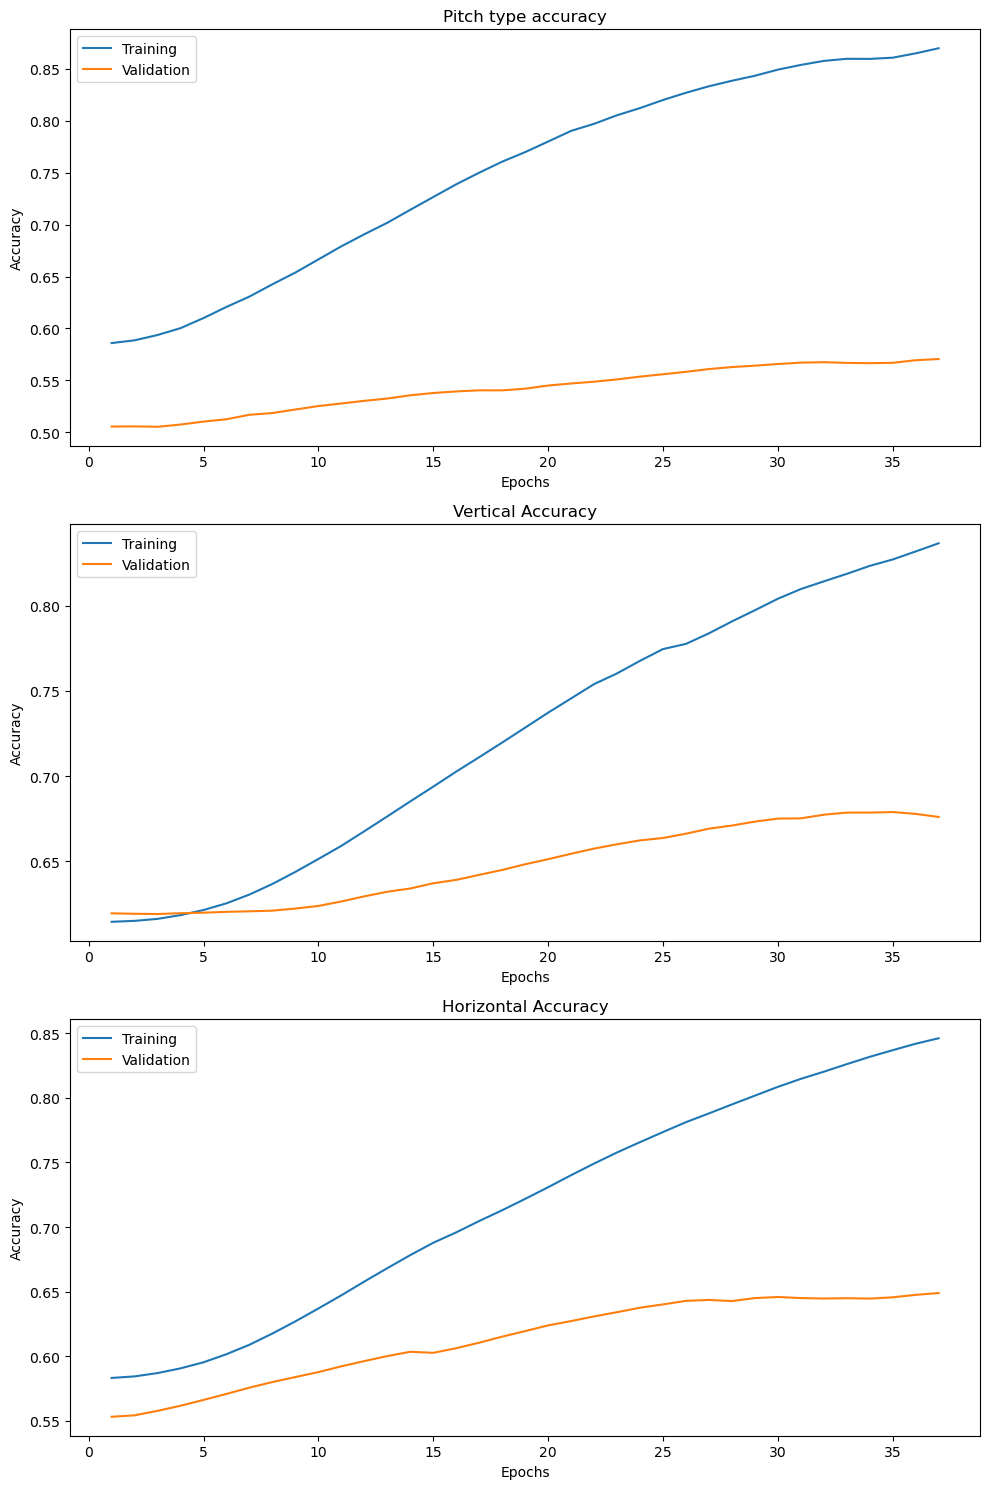

In [18]:
plot_ensemble_history(history)

In [19]:
max_pitch_val_accuracy = max(history.history['val_pitch_output_accuracy'])
max_vertical_val_accuracy = max(history.history['val_vertical_output_accuracy'])
max_horizontal_val_accuracy = max(history.history['val_horizontal_output_accuracy'])

print(f"Max Pitch Validation Accuracy: {max_pitch_val_accuracy}")
print(f"Max Vertical Validation Accuracy: {max_vertical_val_accuracy}")
print(f"Max Horizontal Validation Accuracy: {max_horizontal_val_accuracy}")

Max Pitch Validation Accuracy: 0.5919811129570007
Max Vertical Validation Accuracy: 0.6964285969734192
Max Horizontal Validation Accuracy: 0.6688005328178406


We can see a considerable increase in each output's accuracy compared to the baseline. Now, it is time to test the final model in the test set.

In [20]:
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - horizontal_output_accuracy: 0.6642 - loss: 4.6773 - pitch_output_accuracy: 0.6145 - vertical_output_accuracy: 0.6708
Pitch Test Accuracy: 0.6664420366287231
Vertical Test Accuracy: 0.6068059206008911
Horizontal Test Accuracy: 0.6795822381973267


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


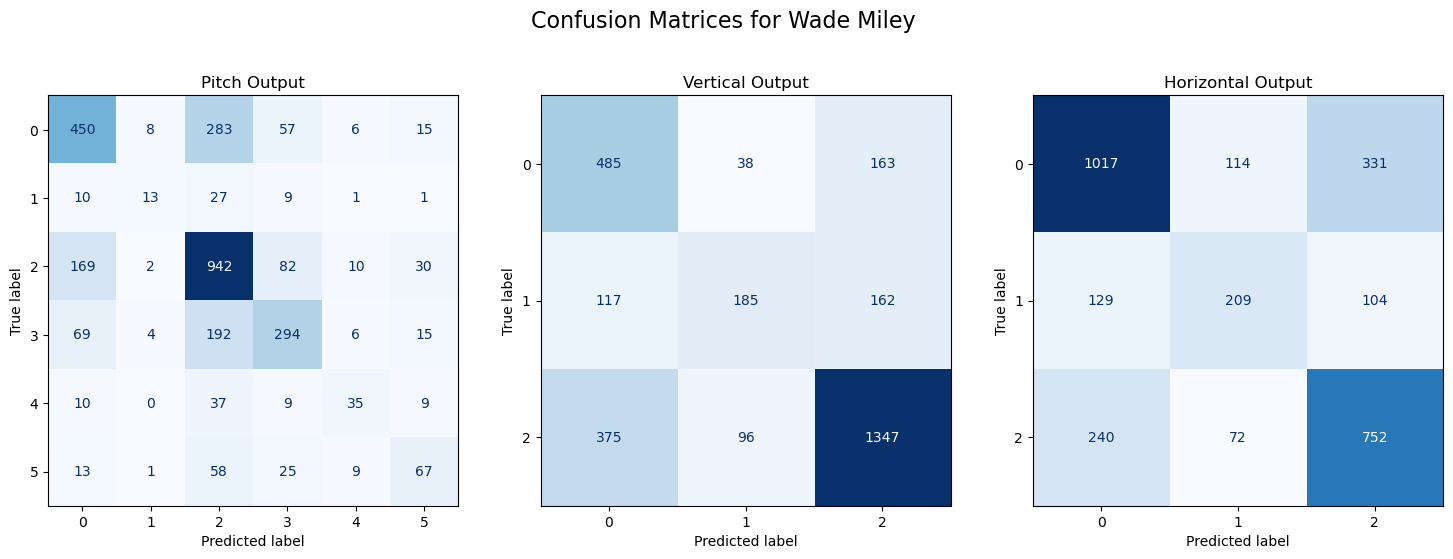

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predictions for all outputs
y_pred = model.predict(X_test)

# Create a figure with subplots for all three confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Confusion Matrices for Wade Miley", fontsize=16)

# Process pitch output
y_pitch_pred_classes = np.argmax(y_pred[0], axis=1)
y_pitch_true_classes = np.argmax(y_pitch_test, axis=1)
cm_pitch = confusion_matrix(y_pitch_true_classes, y_pitch_pred_classes)
disp_pitch = ConfusionMatrixDisplay(confusion_matrix=cm_pitch, display_labels=np.arange(cm_pitch.shape[0]))
disp_pitch.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
axes[0].set_title("Pitch Output")

# Process vertical output
y_vertical_pred_classes = np.argmax(y_pred[1], axis=1)
y_vertical_true_classes = np.argmax(y_vertical_test, axis=1)
cm_vertical = confusion_matrix(y_vertical_true_classes, y_vertical_pred_classes)
disp_vertical = ConfusionMatrixDisplay(confusion_matrix=cm_vertical, display_labels=np.arange(cm_vertical.shape[0]))
disp_vertical.plot(cmap=plt.cm.Blues, ax=axes[1], colorbar=False)
axes[1].set_title("Vertical Output")

# Process horizontal output
y_horizontal_pred_classes = np.argmax(y_pred[2], axis=1)
y_horizontal_true_classes = np.argmax(y_horizontal_test, axis=1)
cm_horizontal = confusion_matrix(y_horizontal_true_classes, y_horizontal_pred_classes)
disp_horizontal = ConfusionMatrixDisplay(confusion_matrix=cm_horizontal, display_labels=np.arange(cm_horizontal.shape[0]))
disp_horizontal.plot(cmap=plt.cm.Blues, ax=axes[2], colorbar=False)
axes[2].set_title("Horizontal Output")

plt.show()

The results are very promising providing a significant improvement over the baseline.